In [1]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from typing import List
import random
import cv2
%matplotlib inline

In [2]:
MAX_COLOR_SCALE = 255
NOISE_PERCENTAGE = 0.005

def get_image_scale(im: ndarray, c: int) -> ndarray:
    assert len(im.shape) == 3 and im.shape[-1] == 3
    return im[:,:,c]

def set_image_scale(im: ndarray, c: int, to: ndarray):
    assert len(im.shape) == 3 and im.shape[-1] == 3
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im[i][j][c] = to[i][j]

def generate_noise(im: ndarray) -> ndarray:
    result: ndarray = MAX_COLOR_SCALE * np.ones(im.shape, dtype=im.dtype)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if random.random() > NOISE_PERCENTAGE:
                result[i][j] = im[i][j]
    return result

def generate_noise_rgb(im: ndarray) -> ndarray:
    result: ndarray = np.zeros(im.shape, dtype=im.dtype)
    for i in range(3):
        set_image_scale(result, i, generate_noise(get_image_scale(im, i)))
    return result

def get_converted_image(im: ndarray) -> ndarray:
    assert len(im.shape) == 3 and im.shape[-1] == 3
    b, g, r = cv2.split(im)
    return cv2.merge([r, g, b])

def plt_show(im: ndarray) -> ndarray:
    plt.imshow(get_converted_image(im))
    plt.show()

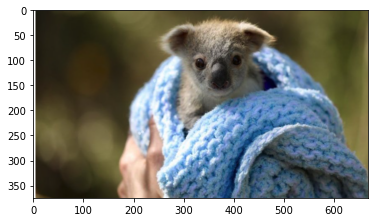

In [3]:
IMAGE_PATH = "images/koala.png"
IMAGE_NAME = IMAGE_PATH.split('.')[-2]

im = cv2.imread(IMAGE_PATH)
plt_show(im)

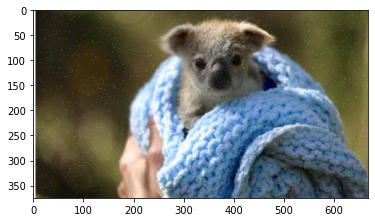

In [4]:
im = generate_noise_rgb(im)
cv2.imwrite(f"{IMAGE_NAME}-with-noise.png", im)
plt_show(im)

In [5]:
def get_distribution(im: ndarray) -> ndarray:
    L: int = im.min()
    R: int = im.max()
    N: int = im.shape[0]
    M: int = im.shape[1]
    size: int = N * M

    color_freq: List = [0] * (R + 1)
    for i in range(N):
        for j in range(M):
            color_freq[int(im[i][j])] += 1
    
    p: ndarray = np.zeros(R+1, dtype=float)
    for i in range(L, R+1):
        if i > 0:
            color_freq[i] += color_freq[i - 1]
            p[i] = color_freq[i] / size

    assert abs(p[-1] - 1) < 1e-5
    return p
    

In [6]:
WINDOW_SIDE = 4
R = WINDOW_SIDE # gives the best result
NOISE_THRESHOLD = 0.01

def gfilter(im: ndarray) -> ndarray:
    dist: ndarray = get_distribution(im)

    im = np.pad(im, ((WINDOW_SIDE, WINDOW_SIDE), (WINDOW_SIDE, WINDOW_SIDE)), 'edge')
    N: int = im.shape[0]
    M: int = im.shape[1]

    result: ndarray = np.zeros(im.shape, dtype=im.dtype)

    for i in range(WINDOW_SIDE, N - WINDOW_SIDE):
        for j in range(WINDOW_SIDE, M - WINDOW_SIDE):
            if dist[int(im[i][j])] > NOISE_THRESHOLD and dist[int(im[i][j])] < 1 - NOISE_THRESHOLD:
                result[i][j] = im[i][j]
                continue

            W1: List = []
            W2: List = []
            W3: List = []
            W4: List = []

            for k in range(-WINDOW_SIDE, WINDOW_SIDE+1):
                if k == 0:
                    continue
                W1.append(im[i][j + k])
                W2.append(im[i + k][j + k])
                W3.append(im[i + k][j])
                W4.append(im[i - k][j + k])

            W1 = sorted(W1)
            W2 = sorted(W2)
            W3 = sorted(W3)
            W4 = sorted(W4)

            index: int = R - 1
            s1: float = max([W1[index], W2[index], W3[index], W4[index]])
            
            reversedIndex: int = 2 * WINDOW_SIDE - R
            s2: float = max([W1[reversedIndex], W2[reversedIndex], W3[reversedIndex], W4[reversedIndex]])
            result[i][j] = sorted([s1, s2, im[i][j]])[1]

    return result[WINDOW_SIDE: -WINDOW_SIDE, WINDOW_SIDE: -WINDOW_SIDE]

def gfilter_rgb(im: ndarray) -> ndarray:
    assert len(im.shape) == 3 and im.shape[-1] == 3
    result: ndarray = np.zeros(im.shape, dtype=im.dtype)
    for i in range(3):
        set_image_scale(result, i, gfilter(get_image_scale(im, i)))
    return result

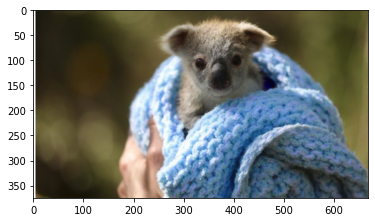

In [7]:

im = gfilter_rgb(im)
cv2.imwrite(f'{IMAGE_NAME}-filtered.improved.png', im)
plt_show(im)